# Import Library

In [ ]:
# Import Library
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from collections import Counter

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning
from gensim.models import FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

# Hyperparameter Tuning
from keras_tuner.tuners import BayesianOptimization

# Model Performance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import matplotlib.ticker as mtick


# Load File & Label Encoder

In [2]:
file_path =  r".\Pre_Dataset\Final.csv"
data = pd.read_csv(file_path)
data.info()

X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158167 entries, 0 to 158166
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    158167 non-null  object
 1   label   158167 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


# Data Preparation

In [3]:
file_path =  r".\Pre_Dataset\Final.csv"
data = pd.read_csv(file_path)

X = data['text'].astype(str).values  
Y = data['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

max_words = 20000  # vocab size
max_len = 200  # the max length of the each sentences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padding = pad_sequences(X_seq, maxlen=max_len)

# Train-Valid-Test Split
# First split into train 70%, valid 20% + test 10%
X_train, X_valid_test, Y_train, Y_valid_test = train_test_split(X_padding, Y,  test_size=0.3, stratify=Y, random_state=42)
# get 10% of valid data as test
X_valid, X_test, Y_valid, Y_test = train_test_split( X_valid_test, Y_valid_test, test_size=0.1, stratify=Y_valid_test, random_state=42)

# Undersampling
print("\nClass distribution before resampling (total dataset):", Counter(Y))
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, Y_train)

print("\nX_train shape", x_train_resampled.shape)
print("Y_train shape", y_train_resampled.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

print("\nClass distribution after resampling (80% Train Set):", Counter(y_train_resampled))
print("Class distribution (10% Validation Set):", Counter(Y_valid))
print("Class distribution (10% Test Set):", Counter(Y_test))

print(f"\nTotal number of training samples after resampling: {x_train_resampled.shape[0]}")


Class distribution before resampling (total dataset): Counter({0: 143076, 1: 15091})

X_train shape (21128, 200)
Y_train shape (21128,)
X_valid shape (42705, 200)
Y_valid shape (42705,)
X_test shape (4746, 200)
Y_test shape (4746,)

Class distribution after resampling (80% Train Set): Counter({0: 10564, 1: 10564})
Class distribution (10% Validation Set): Counter({0: 38631, 1: 4074})
Class distribution (10% Test Set): Counter({0: 4293, 1: 453})

Total number of training samples after resampling: 21128


# Base Model

In [ ]:
MAX_SEQUENCE_LENGTH = 200  
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 20000

model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"),
    MaxPooling1D(pool_size=3),
    Bidirectional(LSTM(64, return_sequences=True)), 
    Dropout(0.2),  
    Bidirectional(LSTM(64, return_sequences=False)), 
    Dropout(0.3),  
    Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')  
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

history = model.fit(x_train_resampled, y_train_resampled, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_valid, Y_valid))


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 123s 172ms/step - accuracy: 0.7691 - loss: 0.4837 - val_accuracy: 0.8640 - val_loss: 0.3031
Epoch 2/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 131s 198ms/step - accuracy: 0.9216 - loss: 0.2038 - val_accuracy: 0.8423 - val_loss: 0.3463
Epoch 3/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - accuracy: 0.9512 - loss: 0.1281 - val_accuracy: 0.8788 - val_loss: 0.3204
Epoch 4/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 148s 224ms/step - accuracy: 0.9764 - loss: 0.0647 - val_accuracy: 0.8512 - val_loss: 0.5347
Epoch 5/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 162s 245ms/step - accuracy: 0.9830 - loss: 0.0457 - val_accuracy: 0.8065 - val_loss: 0.7085
Epoch 6/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 155s 235ms/step - accuracy: 0.9854 - loss: 0.0406 - val_accuracy: 0.8427 - val_loss: 0.5803
Epoch 7/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 161s 244ms/step - accuracy: 0.9889 - loss: 0.0316 - val_accuracy: 0.8704 - val_loss: 0.5837
Epoch 8/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 127s 192ms/step - accuracy: 0.9894 -

In [5]:
model.save("CNN_BiLSTM_Default_Model.h5")
joblib.dump(history.history, "CNN_BiLSTM_Default_History.pkl")
print("Model saved successfully!")

Model saved successfully!


## Evaluate

In [6]:
# Evaluete Model -------------------------------------------------------------------------------------------------
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_valid, Y_valid, verbose=1)

y_pred_prob = model.predict(X_valid)

661/661 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9879 - loss: 0.0242
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.8498 - loss: 0.7632
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step


In [12]:

y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Validation Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))



📌 Train Accuracy: 0.9919
📌 Validation Accuracy: 0.8517

📌 Weighted F1 Score: 0.8751
📌 Precision: 0.6799
📌 Recall: 0.8530

📌 ROC AUC: 0.9295

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     38631
           1       0.38      0.85      0.52      4074

    accuracy                           0.85     42705
   macro avg       0.68      0.85      0.72     42705
weighted avg       0.92      0.85      0.88     42705


📌 Confusion Matrix:
[[32888  5743]
 [  592  3482]]


## Precision-Recall & Thresholds

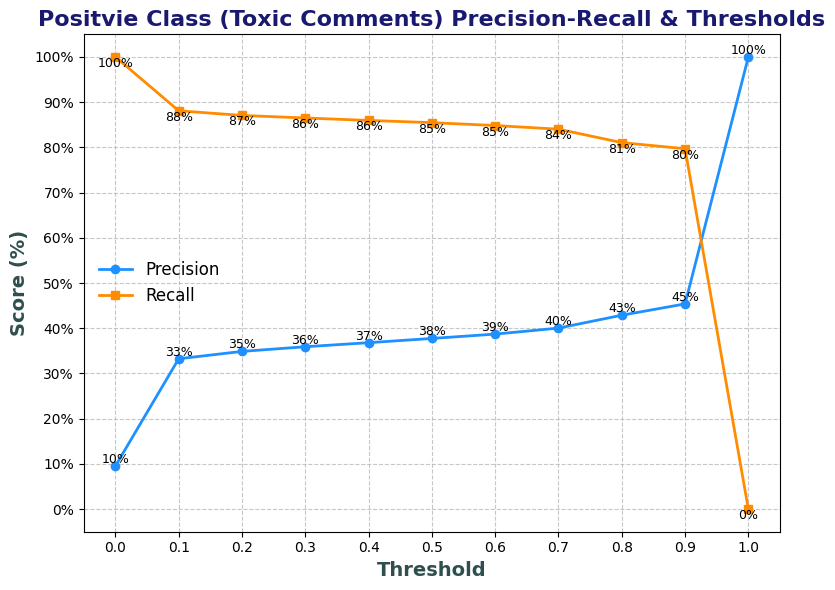

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

precision, recall, thresholds = precision_recall_curve(Y_valid, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

interp_thresholds = np.arange(0.0, 1.01, 0.1)  
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.xticks(interp_thresholds)  

for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## confusion_matrix

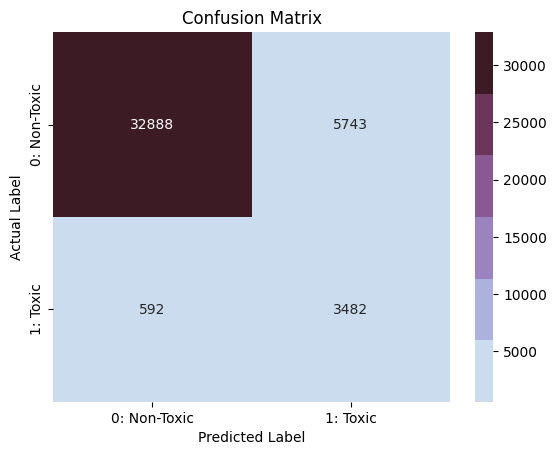

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Learning Curve

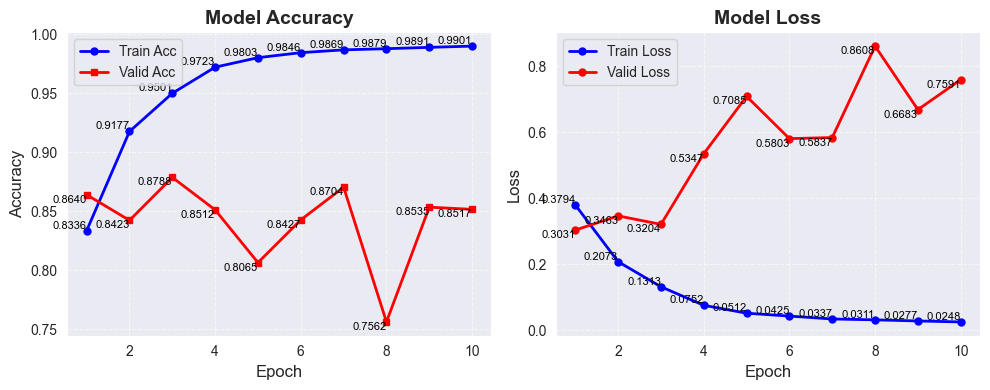

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )
sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## ROC-AUC


📌 ROC AUC: 0.9295


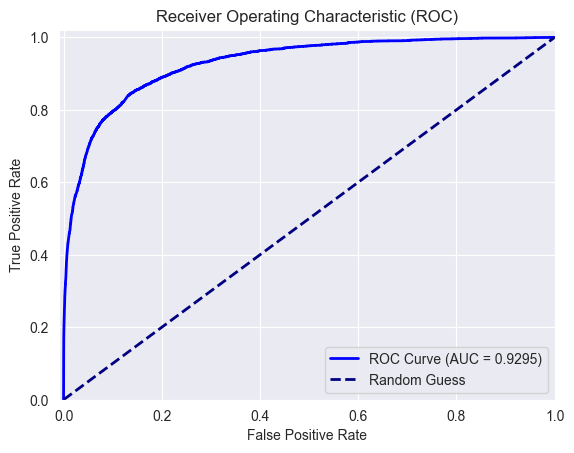

In [15]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## PR Curve


📌 Precision-Recall AUC: 0.7084


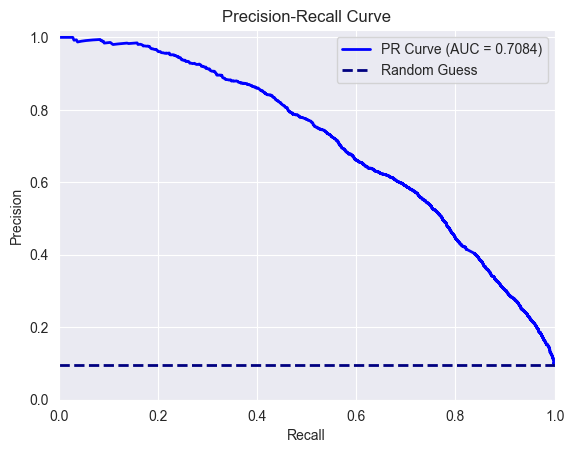

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_valid) / len(Y_valid)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


# Hyperparameter Tuning

In [ ]:
MAX_SEQUENCE_LENGTH = 200  
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 20000

# fastText dowload from: https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)

# declare matrix
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv: # If the word exists in the pretrained word vectors
            embedding_matrix[i] = word_vectors.wv[word] # Assign the pretrained embedding to the corresponding index
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,)) # For out-of-vocab,initialize randomly

# embedding_matrix = np.load("embedding_matrix_20k_200.npy")

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)
# np.save("embedding_matrix_20k.npy", embedding_matrix)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

def build_model(hp):
    model = Sequential()
    model.add(embedding_layer)
    # The kernel size determines the number of words processed in each convolution operation， for example, kernel size=3 means processing 3 words at a time
    model.add(Conv1D(filters=hp.Int("conv_filters", min_value=32, max_value=256, step=32),
                     kernel_size=hp.Int("kernel_size", min_value=3, max_value=5, step=1), activation='relu',padding='same'))
    model.add(MaxPooling1D(pool_size=hp.Int("pool_size", min_value=2, max_value=5, step=1))) # Apply 1D max pooling to downsample the feature maps

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_1", min_value=64, max_value=256, step=64),return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_2", min_value=32, max_value=128, step=32),return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_3", min_value=16, max_value=64, step=16),return_sequences=False)))
    model.add(Dropout(hp.Float("dropout_3", min_value=0.2, max_value=0.4, step=0.1)))
    
    model.add(Dense(units=hp.Int("dense_units", min_value=16, max_value=64, step=16), 
                    activation=hp.Choice("activation", ["relu", "tanh","sigmoid"]),  
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_reg", min_value=0.001, max_value=0.07, step=0.005))))
    model.add(Dense(1, activation="sigmoid"))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'adagrad'])
    learning_rate = hp.Choice("learning_rate", [0.0001, 0.003, 0.01, 0.03])
    if optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,loss="binary_crossentropy",metrics=["accuracy"])
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir_CNN_BiLSTM',
    project_name='1_HP_CNN_BiLSTM'
)

tuner.search(x_train_resampled,y_train_resampled, 
             epochs=10,
             batch_size=32,
             validation_data=(X_valid,Y_valid))


Trial 10 Complete [00h 13m 54s]
val_accuracy: 0.9046013355255127

Best val_accuracy So Far: 0.916239321231842
Total elapsed time: 02h 20m 03s


## Best HP

In [19]:
best_model = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""Best Hyperparameter:
        CNN  conv_filters: {best_model.get('conv_filters')}
        CNN  kernel_size: {best_model.get('kernel_size')}
        CNN  pool_size: {best_model.get('pool_size')}
        Bi-LSTM  Layer 1: {best_model.get('LSTM_layer_1')}
        Bi-LSTM  Layer 2: {best_model.get('LSTM_layer_2')}
        Bi-LSTM  Layer 3: {best_model.get('LSTM_layer_3')}
        Dropout 1: {best_model.get('dropout_1')}
        Dropout 2: {best_model.get('dropout_2')}
        Dropout 3: {best_model.get('dropout_3')}
        Dense : {best_model.get('dense_units')}
        Activation : {best_model.get('activation')}
        Learning Rate : {best_model.get('learning_rate')}
        Optimizer Choice: {best_model.get('optimizer')}
        L2: {best_model.get('l2_reg')}
        """)

Best Hyperparameter:
        CNN  conv_filters: 160
        CNN  kernel_size: 4
        CNN  pool_size: 4
        Bi-LSTM  Layer 1: 128
        Bi-LSTM  Layer 2: 32
        Bi-LSTM  Layer 3: 32
        Dropout 1: 0.30000000000000004
        Dropout 2: 0.4
        Dropout 3: 0.2
        Dense : 48
        Activation : tanh
        Learning Rate : 0.003
        Optimizer Choice: sgd
        L2: 0.016
        


In [ ]:
model = build_model(best_model)
history = model.fit(x_train_resampled, y_train_resampled, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_valid, Y_valid))

model.summary()

joblib.dump(tuner, "1_HP_CNN_BiLSTM_Tuner.pkl")
model.save("1_HP_CNN_BiLSTM_Model.h5") 
joblib.dump(history.history, "1_HP_CNN_BiLSTM_History.pkl")
print("Saved successfully!")

Epoch 1/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 79s 110ms/step - accuracy: 0.5288 - loss: 1.3785 - val_accuracy: 0.4810 - val_loss: 0.9314
Epoch 2/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 63s 95ms/step - accuracy: 0.5852 - loss: 0.8702 - val_accuracy: 0.4378 - val_loss: 0.7751
Epoch 3/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.5925 - loss: 0.7254 - val_accuracy: 0.5594 - val_loss: 0.6666
Epoch 4/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step - accuracy: 0.5965 - loss: 0.6869 - val_accuracy: 0.6090 - val_loss: 0.6333
Epoch 5/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 64s 96ms/step - accuracy: 0.6084 - loss: 0.6668 - val_accuracy: 0.8690 - val_loss: 0.5240
Epoch 6/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.6796 - loss: 0.5978 - val_accuracy: 0.8286 - val_loss: 0.4628
Epoch 7/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 71s 107ms/step - accuracy: 0.7201 - loss: 0.5443 - val_accuracy: 0.8310 - val_loss: 0.4561
Epoch 8/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.7469 - loss: 0.513

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 160)       │       192,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 160)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 50, 256)        │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 50, 64)         │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,180,164 (27.39 MB)

 Trainable params: 590,081 (2.25 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

 Optimizer params: 590,083 (2.25 MB)

Saved successfully!


## Evaluation

In [8]:
# Evaluete Model -------------------------------------------------------------------------------------------------
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_valid, Y_valid, verbose=1)

y_pred_prob = model.predict(X_valid)

661/661 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8717 - loss: 0.3577
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.8636 - loss: 0.3766
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step


In [15]:

y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Validation Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))



📌 Train Accuracy: 0.8037
📌 Validation Accuracy: 0.8637

📌 Weighted F1 Score: 0.8805
📌 Precision: 0.6736
📌 Recall: 0.7887

📌 ROC AUC: 0.8741

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     38631
           1       0.38      0.70      0.49      4074

    accuracy                           0.86     42705
   macro avg       0.67      0.79      0.71     42705
weighted avg       0.91      0.86      0.88     42705


📌 Confusion Matrix:
[[34051  4580]
 [ 1239  2835]]


Threshold 0.8

In [ ]:
from sklearn.metrics import accuracy_score
train_y_pred_prob = model.predict(x_train_resampled)
y_pred_prob = model.predict(X_valid)

train_y_pred = (train_y_pred_prob > 0.8).astype(int)
valid_accuracy = accuracy_score(y_train_resampled, train_y_pred) 
print(f"📌 Train Accuracy: {valid_accuracy:.4f}")

y_pred = (y_pred_prob > 0.8).astype(int)
valid_accuracy = accuracy_score(Y_valid, y_pred)
print(f"📌 Validation Accuracy: {valid_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)
print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))


📌 Train Accuracy: 0.7234
📌 Validation Accuracy: 0.9300

📌 Weighted F1 Score: 0.9226
📌 Precision: 0.8280
📌 Recall: 0.7138

📌 ROC AUC: 0.8741

📌 Precision-Recall AUC: 0.6220

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     38631
           1       0.71      0.45      0.55      4074

    accuracy                           0.93     42705
   macro avg       0.83      0.71      0.76     42705
weighted avg       0.92      0.93      0.92     42705


📌 Confusion Matrix:
[[37895   736]
 [ 2254  1820]]


## Confusion matrix

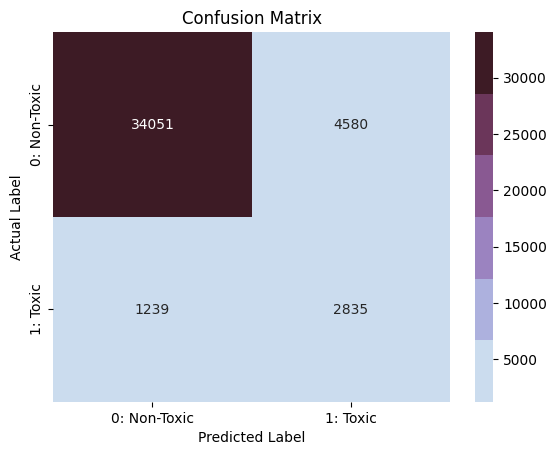

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()

## Learning Curve

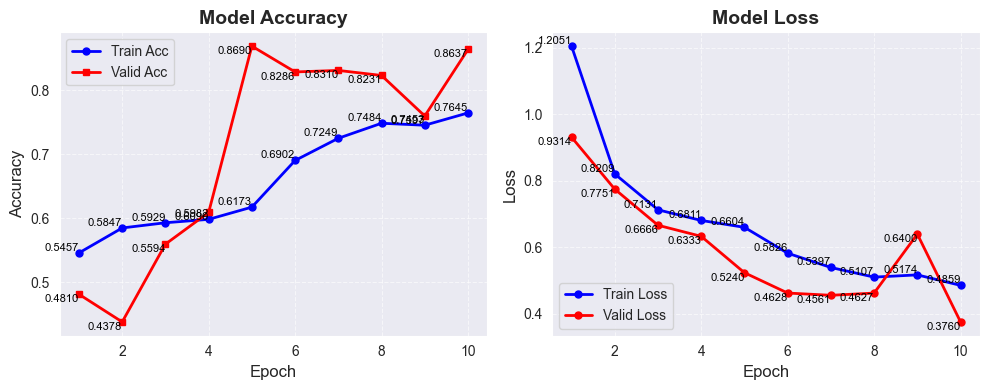

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )


sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## ROC-AUC


📌 ROC AUC: 0.8741


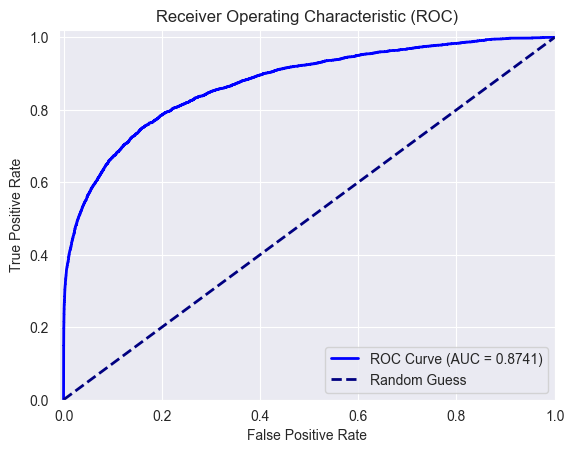

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## PR Curve


📌 Precision-Recall AUC: 0.6220


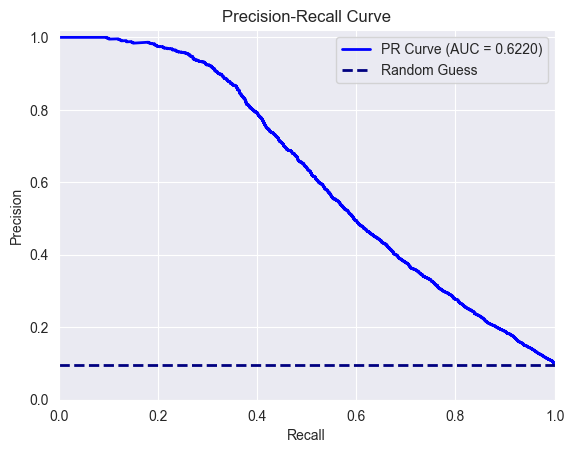

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_valid) / len(Y_valid)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Threshold

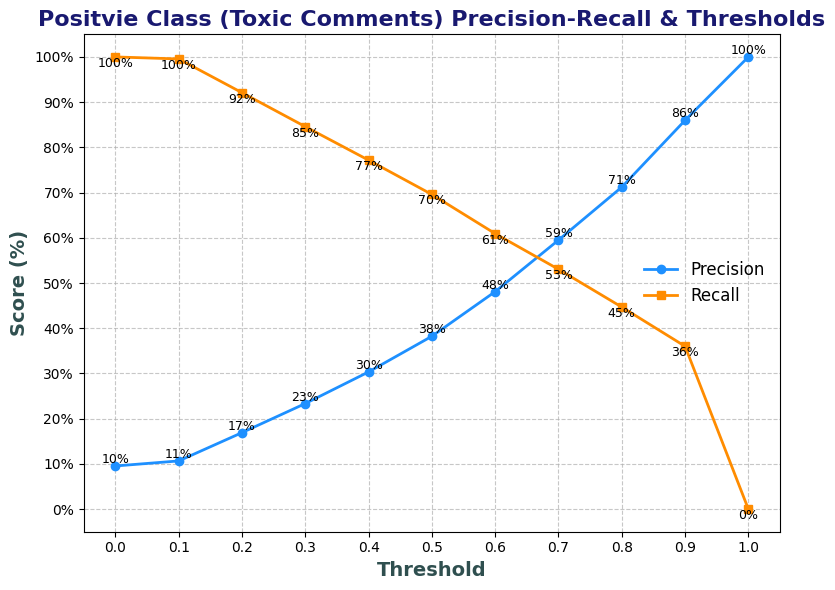

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

precision, recall, thresholds = precision_recall_curve(Y_valid, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

interp_thresholds = np.arange(0.0, 1.01, 0.1)  
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.xticks(interp_thresholds)  

for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Fine Tuning 

In [ ]:
MAX_SEQUENCE_LENGTH = 200  
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 20000

# https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)

# declare matrix
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))   

# embedding_matrix = np.load("embedding_matrix_20k_200.npy")

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)
# np.save("embedding_matrix_20k.npy", embedding_matrix)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

# When saving the model, Keras will automatically recognize my_custom_loss and load it correctly
@register_keras_serializable(package="CustomLoss")
# Function focal_loss code et from GitHub (aldi-dimara, 2018)
# Gamma, Alpha default values ​​recommended by the paper (Lin et al., 2018) # https://arxiv.org/pdf/1708.02002v2 
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.55):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    # Predicted probability of the correct class
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    # Alpha factor for balancing class imbalance. 
    alpha_factor = K.ones_like(y_true)*alpha
    # Dynamically assigns different alpha values to different classes
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    # Cross-entropy loss
    cross_entropy = -K.log(pt)
    # Alpha > 0.5, then class 1 weigth > class 0 weigth. Alpha < 0.5, then class 0 weigth > class 1 weigth
    weight = alpha_t * K.pow((1-pt), gamma) #alpha_t*(1 - pt) ^ gamma
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = Sequential([
    embedding_layer,
    Conv1D(filters=160, kernel_size=4, activation="relu", padding="same"),
    MaxPooling1D(pool_size=4),
    
    Bidirectional(LSTM(128, return_sequences=True)), 
    Dropout(0.3),  
    Bidirectional(LSTM(32, return_sequences=True)), 
    Dropout(0.4),  
    Bidirectional(LSTM(32, return_sequences=False)), 
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)),
    Dense(1, activation='sigmoid')  
])

model.compile(
    loss=focal_loss,
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train_resampled, y_train_resampled, 
                    epochs=15, batch_size=32, 
                    validation_data=(X_valid, Y_valid),
                    callbacks=[early_stopping],
                    )


Epoch 1/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 80s 111ms/step - accuracy: 0.6111 - loss: 2.5529 - val_accuracy: 0.7582 - val_loss: 1.3654
Epoch 2/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - accuracy: 0.7977 - loss: 1.1220 - val_accuracy: 0.8373 - val_loss: 0.5671
Epoch 3/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.8361 - loss: 0.4605 - val_accuracy: 0.7926 - val_loss: 0.2345
Epoch 4/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.8701 - loss: 0.1764 - val_accuracy: 0.8779 - val_loss: 0.0904
Epoch 5/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.9083 - loss: 0.0688 - val_accuracy: 0.8486 - val_loss: 0.0590
Epoch 6/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - accuracy: 0.9351 - loss: 0.0348 - val_accuracy: 0.6049 - val_loss: 0.1206
Epoch 7/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 84s 127ms/step - accuracy: 0.9483 - loss: 0.0252 - val_accuracy: 0.8870 - val_loss: 0.0423
Epoch 8/15
661/661 ━━━━━━━━━━━━━━━━━━━━ 87s 132ms/step - accuracy: 0.9627 - loss: 0

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 160)       │       192,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 160)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 64)         │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,767,077 (29.63 MB)

 Trainable params: 589,025 (2.25 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

 Optimizer params: 1,178,052 (4.49 MB)

In [ ]:
model.save("Fine_CNN_Fine_Model.keras") 
joblib.dump(history.history, "Fine_CNN_Fine_History.pkl")

['Fine_CNN_Fine_History.pkl']

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score

train_y_pred_prob = model.predict(x_train_resampled)
y_pred_prob = model.predict(X_valid)

661/661 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step


In [ ]:
train_y_pred = (train_y_pred_prob > 0.5).astype(int)
valid_accuracy = accuracy_score(y_train_resampled, train_y_pred) 
print(f"📌 Train Accuracy: {valid_accuracy:.4f}")

y_pred = (y_pred_prob > 0.5).astype(int)
valid_accuracy = accuracy_score(Y_valid, y_pred)
print(f"📌 Validation Accuracy: {valid_accuracy:.4f}")

f1_weighted = f1_score(Y_valid, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_valid, y_pred, average='macro') 
recall = recall_score(Y_valid, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_valid, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_valid, y_pred))


📌 Train Accuracy: 0.9460
📌 Validation Accuracy: 0.8870

📌 Weighted F1 Score: 0.8999
📌 Precision: 0.7104
📌 Recall: 0.8359

📌 ROC AUC: 0.9121

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     38631
           1       0.45      0.77      0.57      4074

    accuracy                           0.89     42705
   macro avg       0.71      0.84      0.75     42705
weighted avg       0.92      0.89      0.90     42705


📌 Confusion Matrix:
[[34733  3898]
 [  926  3148]]


## confusion_matrix

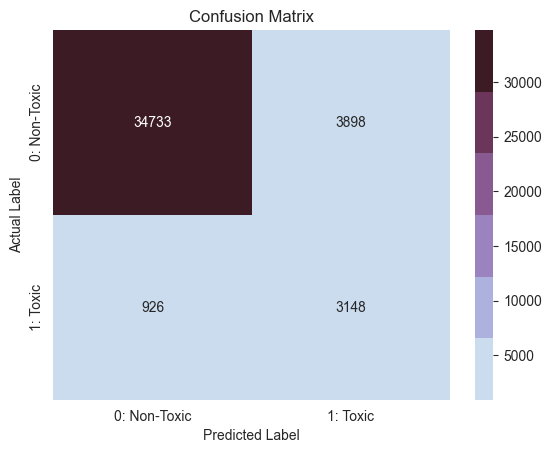

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d",cmap = sns.color_palette("ch:start=1,rot=-.5"),
            xticklabels=['0: Non-Toxic', '1: Toxic'], 
            yticklabels=['0: Non-Toxic', '1: Toxic'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Learning Curve

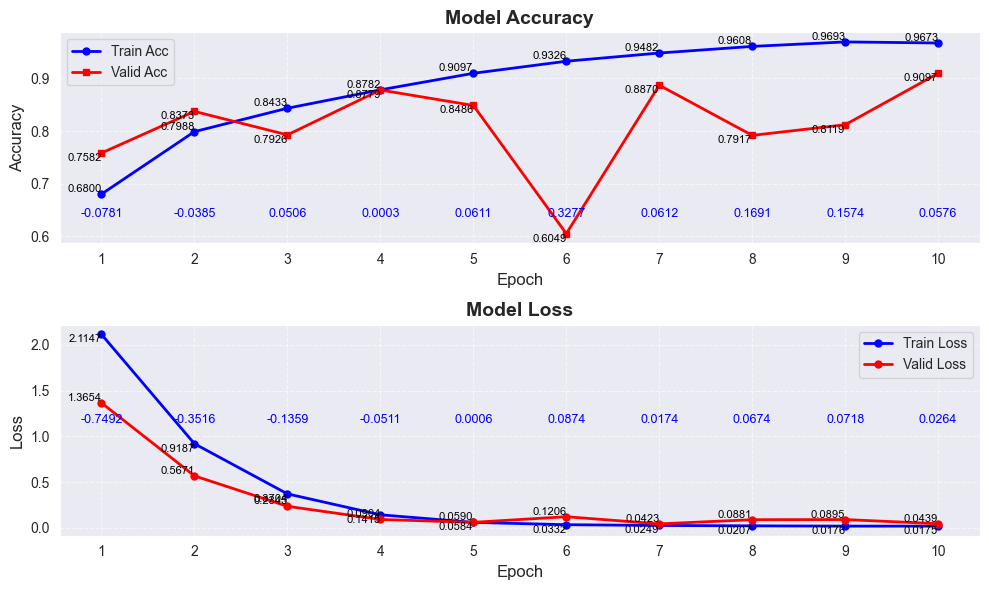

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) -0.05, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) +1.1, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    

plt.tight_layout()
plt.show()


## ROC-AUC


📌 ROC AUC: 0.9121


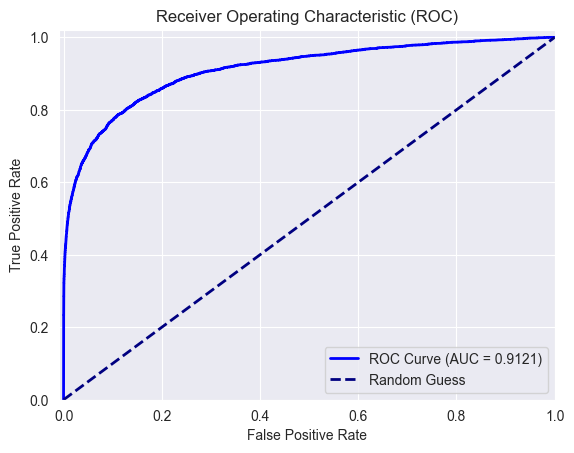

In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## PR Curve


📌 Precision-Recall AUC: 0.7259


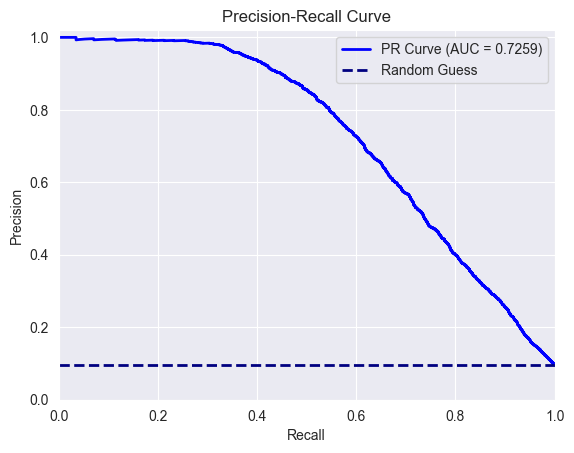

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_valid, y_pred_prob)
pr_auc = average_precision_score(Y_valid, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_valid) / len(Y_valid)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


## Threshold

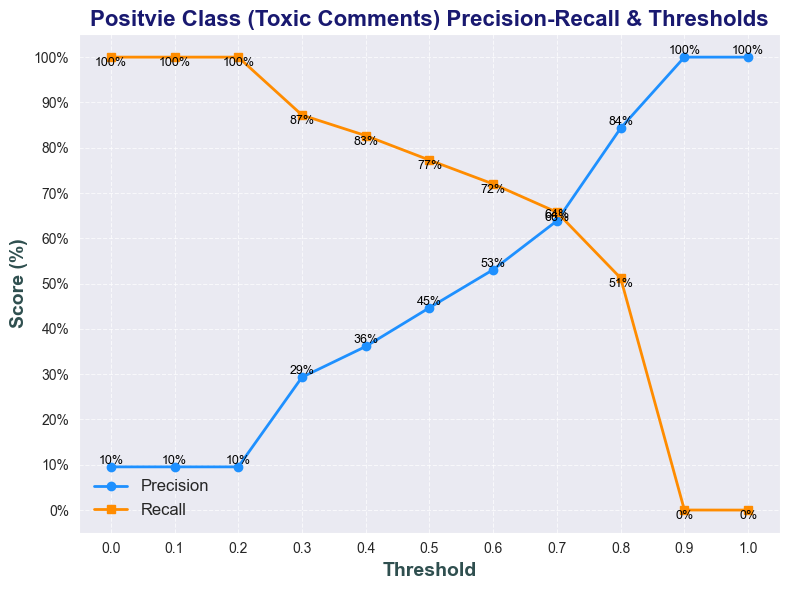

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

precision, recall, thresholds = precision_recall_curve(Y_valid, y_pred_prob)

thresholds_full = np.append(thresholds, 1.0)

interp_thresholds = np.arange(0.0, 1.01, 0.1)  
precision_interp = np.interp(interp_thresholds, thresholds_full, precision)
recall_interp = np.interp(interp_thresholds, thresholds_full, recall)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(interp_thresholds, precision_interp, label="Precision", color='dodgerblue', linewidth=2, marker='o')
plt.plot(interp_thresholds, recall_interp, label="Recall", color='darkorange', linewidth=2, marker='s')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.xticks(interp_thresholds)  

for t, p, r in zip(interp_thresholds, precision_interp, recall_interp):
    plt.text(t, p, f'{p*100:.0f}%', fontsize=9, color='black', ha='center', va='bottom')
    plt.text(t, r, f'{r*100:.0f}%', fontsize=9, color='black', ha='center', va='top')

plt.xlabel("Threshold", fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold', color='darkslategray')
plt.title("Positvie Class (Toxic Comments) Precision-Recall & Thresholds", fontsize=16, fontweight='bold', color='midnightblue')
plt.legend(loc='best', fontsize=12, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Test set

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

@register_keras_serializable(package="CustomLoss")
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.53):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    pt = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(pt)
    weight = alpha_t * K.pow((1-pt), gamma)
    loss = weight * cross_entropy
    loss = K.mean(loss, axis=1)
    return loss

model = load_model(
    r"Model Saved/CNN_BiLSTM/Fine_CNN_Fine_Model.keras",
    custom_objects={'focal_loss': focal_loss}
)
y_pred_prob = model.predict(X_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = (y_pred_prob > 0.5).astype(int)
valid_accuracy = accuracy_score(Y_test, y_pred)
print(f"📌 Test Accuracy: {valid_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

precision = precision_score(Y_test, y_pred, average='macro') 
recall = recall_score(Y_test, y_pred, average='macro')

print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌 ROC AUC: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)
print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


📌 Test Accuracy: 0.8803

📌 Weighted F1 Score: 0.8942
📌 Precision: 0.6993
📌 Recall: 0.8213

📌 ROC AUC: 0.9080

📌 Precision-Recall AUC: 0.6878

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4293
           1       0.43      0.75      0.54       453

    accuracy                           0.88      4746
   macro avg       0.70      0.82      0.74      4746
weighted avg       0.92      0.88      0.89      4746


📌 Confusion Matrix:
[[3839  454]
 [ 114  339]]
